# Recognition parameterized model on augmented EMG data

In [150]:
# import os
# import wandb
import copy
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.distributions as torch_dist

from configs import BaseConfig
from lift.datasets import (
    load_all_mad_datasets, 
    mad_groupby_labels,
    mad_labels_to_actions,
    mad_augmentation, 
    compute_features, 
)
from lift.environments.simulator import SimulatorFactory

In [164]:
def load_data(config: BaseConfig):
    mad_windows, mad_labels = load_all_mad_datasets(
        config.mad_base_path.as_posix(),
        num_channels=config.n_channels,
        emg_range=config.emg_range,
        window_size=config.window_size,
        window_overlap=config.window_overlap,
        desired_labels=config.desired_mad_labels,
        skip_person='Female0',
        return_tensors=True,
    )
    mad_features = compute_features(mad_windows)
    mad_actions = mad_labels_to_actions(
        mad_labels, recording_strength=config.simulator.recording_strength,
    )
    mad_actions = torch.clip(mad_actions + torch.randn_like(mad_actions) * 0.2, -1, 1)

    window_list, label_list = mad_groupby_labels(mad_windows, mad_labels)
    actions_list = mad_labels_to_actions(
        label_list, recording_strength=config.simulator.recording_strength,
    )
    sample_windows, sample_actions = mad_augmentation(
        window_list, 
        actions_list, 
        config.pretrain.num_augmentation,
        augmentation_distribution=config.pretrain.augmentation_distribution,
        reduction=config.simulator.reduction,
    )
    sample_features = compute_features(sample_windows)

    sample_features = torch.cat([mad_features, sample_features], dim=0)
    sample_actions = torch.cat([mad_actions, sample_actions], dim=0)

    idx = torch.randperm(len(sample_features))
    sample_features = sample_features[idx]
    sample_actions = sample_actions[idx]
    return sample_features, sample_actions

def load_data_single(config: BaseConfig):
    """Load a single person"""
    data_path = (config.mad_data_path / "Female0"/ "training0").as_posix()
    sim = SimulatorFactory.create_class(
        data_path,
        config,
        return_features=True,
    )
    sample_actions = torch.rand(30_000, 3)
    sample_features = sim(sample_actions)
    return sample_features, sample_actions

In [165]:
torch.manual_seed(0)

config = BaseConfig()
features, actions = load_data(config)
features_single, actions_single = load_data_single(config)
act_dim = actions.shape[-1]
print(features.shape, actions.shape)
print(features_single.shape, actions_single.shape)

def normalize(x, mu, std):
    return (x - mu) / std

features_norm = normalize(
    features,
    features.mean(0),
    features.std(0),
)

features_single_norm = normalize(
    features_single,
    features_single.mean(0),
    features_single.std(0),
)

skipping Female0
skipping Female0
skipping Female0
skipping Female0
MAD dataset loaded
torch.Size([23075, 32]) torch.Size([23075, 3])
torch.Size([30000, 32]) torch.Size([30000, 3])


In [20]:
# get embedding for 2d visualization
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(features_norm)

In [166]:
reducer_single = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings_single = reducer_single.fit_transform(features_single_norm)

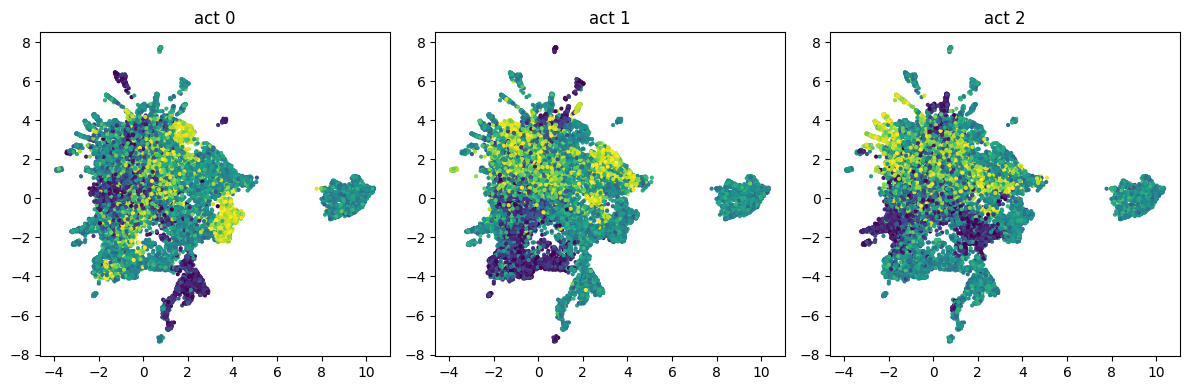

In [21]:
# visualize umap embeddings by action
fig, ax = plt.subplots(1, act_dim, figsize=(4 * act_dim, 4))
for i in range(act_dim):
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=actions[:, i], s=4)
    ax[i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

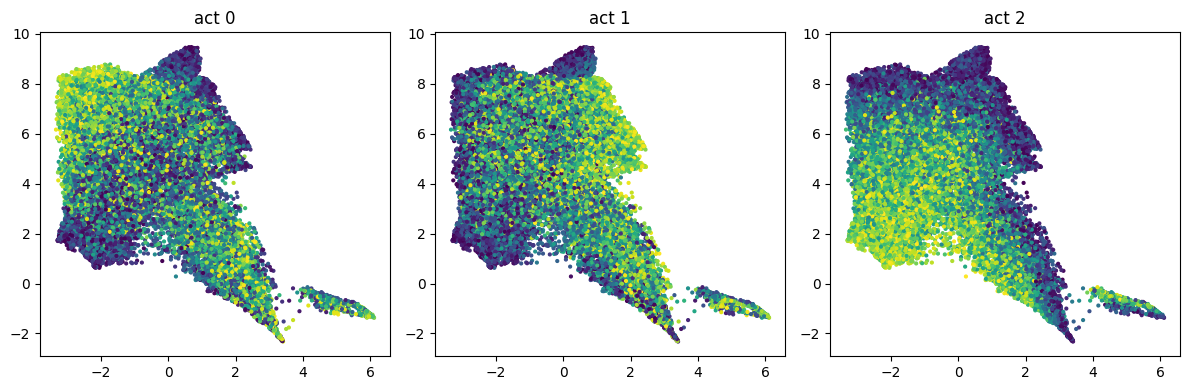

In [167]:
# visualize umap embeddings of a single person
fig, ax = plt.subplots(1, act_dim, figsize=(4 * act_dim, 4))
for i in range(act_dim):
    ax[i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=actions_single[:, i], s=4)
    ax[i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

In [142]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        out = self.network(x)
        return out
    
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim * 2, hidden_dims)
    
    def forward(self, x):
        mu, ls = torch.chunk(self.mlp(x), 2, dim=-1)
        sd = ls.clip(np.log(1e-3)).exp()
        return mu, sd
    
    def encode(self, x):
        mu, sd = self.forward(x)
        mu = torch.tanh(mu)
        return torch_dist.Normal(mu, sd)

## Can we predict actions accurately from features?

In [151]:
def train(model, features, actions, batch_size, epochs, lr):
    train_features = features[:-200]
    train_actions = actions[:-200]
    test_features = features[-200:]
    test_actions = actions[-200:]

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.)

    history = {"train_loss": [], "train_mae": [], "val_loss": [], "val_mae": []}
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(train_features), size=(batch_size,))
        features_batch = train_features[sample_idx]
        actions_batch = train_actions[sample_idx]
        # pred = model(features_batch)
        # loss = nn.SmoothL1Loss().forward(pred, actions_batch)
        dist = model.encode(features_batch)
        loss = -dist.log_prob(actions_batch).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # mae = torch.abs(pred - actions_batch).mean()
            mae = torch.abs(dist.mode - actions_batch).mean()

            # val_pred = model(test_features)
            # val_loss = nn.SmoothL1Loss().forward(val_pred, test_actions)
            # val_mae = torch.abs(val_pred - test_actions).mean()
            val_dist = model.encode(test_features)
            val_loss = -val_dist.log_prob(test_actions).mean()
            val_mae = torch.abs(val_dist.mode - test_actions).mean()

        bar.set_description(f"e: {e}, train_loss: {loss:.2f}, train_mae: {mae:.2}, val_loss: {val_loss:.2f}, val_mae: {val_mae:.2}")
        history["train_loss"].append(loss.data.item())
        history["train_mae"].append(mae.data.item())
        history["val_loss"].append(val_loss.data.item())
        history["val_mae"].append(val_mae.data.item())
    return history

In [154]:
# fit to all people
torch.manual_seed(0)
hidden_dims = [400, 400, 400]
model = GaussianEncoder(
    features_norm.shape[-1],
    actions.shape[-1],
    hidden_dims=hidden_dims,
    # tanh_output=True,
)

batch_size = 512
epochs = 3000
lr = 1e-3
history = train(model, features_norm, actions, batch_size, epochs, lr)

e: 2999, train_loss: -0.55, train_mae: 0.13, val_loss: 3.48, val_mae: 0.27: 100%|██████████| 3000/3000 [00:12<00:00, 242.67it/s]


In [171]:
# fit to one person people
torch.manual_seed(0)
hidden_dims = [400, 400, 400]
model_single = GaussianEncoder(
    features_norm.shape[-1],
    actions.shape[-1],
    hidden_dims=hidden_dims,
    # tanh_output=True,
)

batch_size = 512
epochs = 3000
lr = 1e-3
history_single = train(model_single, features_single_norm, actions_single, batch_size, epochs, lr)

e: 2999, train_loss: -1.00, train_mae: 0.082, val_loss: 0.03, val_mae: 0.11: 100%|██████████| 3000/3000 [00:12<00:00, 244.90it/s] 


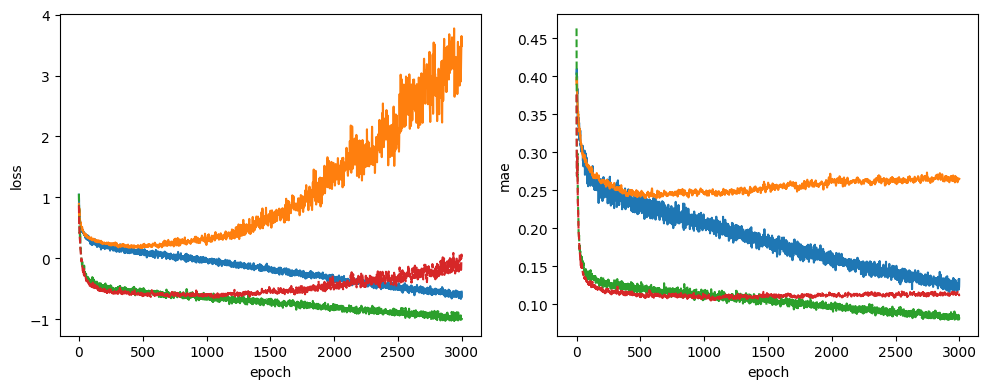

In [172]:
# plot history
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history["train_loss"])
ax[0].plot(history["val_loss"])
ax[0].plot(history_single["train_loss"], "--")
ax[0].plot(history_single["val_loss"], "--")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].plot(history["train_mae"])
ax[1].plot(history["val_mae"])
ax[1].plot(history_single["train_mae"], "--")
ax[1].plot(history_single["val_mae"], "--")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("mae")

plt.tight_layout()
plt.show()

max error tensor([1.5939, 1.3073, 1.4354])


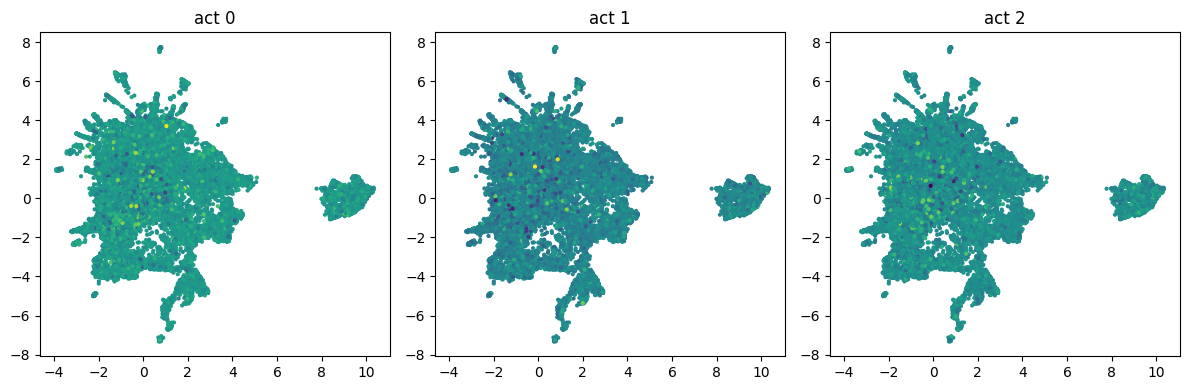

In [157]:
# visualize prediction error
with torch.no_grad():
    error = model.encode(features_norm).mode - actions

print("max error", error.abs().max(0)[0])
    
fig, ax = plt.subplots(1, act_dim, figsize=(4 * act_dim, 4))
for i in range(act_dim):
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=error[:, i], s=4)
    ax[i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

max error tensor([1.9346, 1.8338, 1.9076])


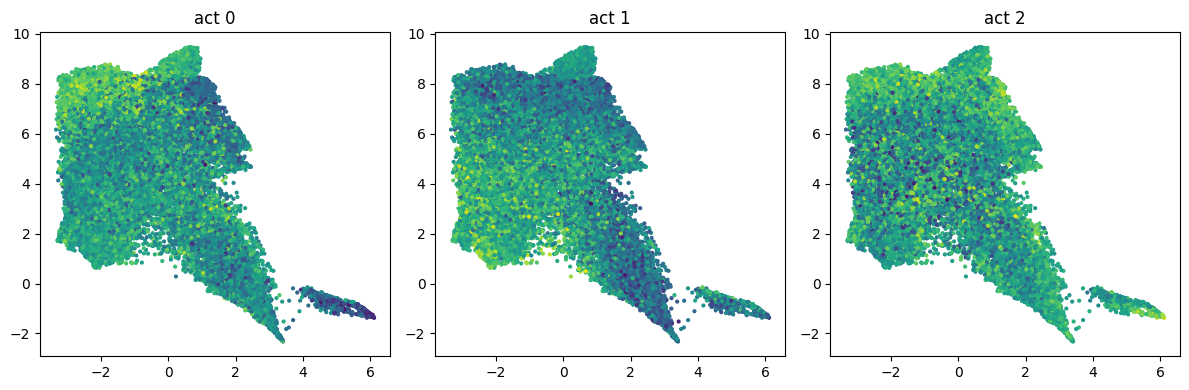

In [173]:
# visualize prediction error one person
with torch.no_grad():
    error = model.encode(features_single_norm).mode - actions_single

print("max error", error.abs().max(0)[0])
    
fig, ax = plt.subplots(1, act_dim, figsize=(4 * act_dim, 4))
for i in range(act_dim):
    ax[i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=error[:, i], s=4)
    ax[i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

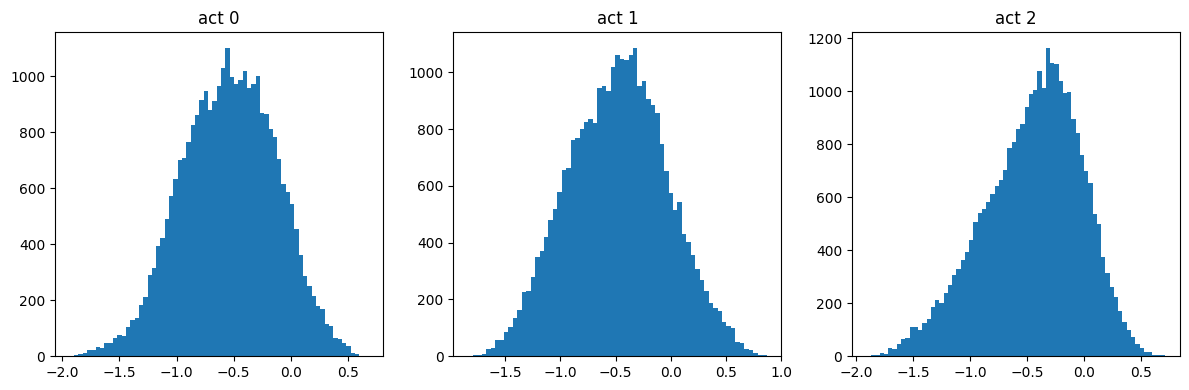

In [174]:
# plot residual histogram
fig, ax = plt.subplots(1, act_dim, figsize=(4 * act_dim, 4))
for i in range(act_dim):
    ax[i].hist(error[:, i].numpy(), bins="fd")
    ax[i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

## Contrastive learning

In [175]:
class RPMCont(nn.Module):
    """Continuous recognition parameterized model"""
    def __init__(self, x_dim, z_dim, hidden_dims, energy_func="f", beta_1=1., beta_2=0.3):
        super().__init__()
        self.energy_func = energy_func
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        if energy_func == "f":
            self.f = MLP(x_dim + z_dim, 1, hidden_dims)
        elif energy_func == "logp":
            self.f = GaussianEncoder(x_dim, z_dim, hidden_dims)
            # self.f = MLP(x_dim, z_dim, hidden_dims)
        
        self.encoder = GaussianEncoder(x_dim, z_dim, hidden_dims)
    
    def forward_f(self, x, z):
        f = self.f(torch.cat([x, z], dim=-1))

        sample_idx_neg = torch.randint(len(x), size=(50,)) # hard code number of negative samples
        x_neg = x[sample_idx_neg]
        x_neg_ = x_neg.unsqueeze(0).repeat_interleave(len(x), dim=0)
        z_ = z.unsqueeze(1).repeat_interleave(len(x_neg), dim=1)
        f_neg_ = self.f(torch.cat([x_neg_, z_], dim=-1))
        f_neg_ = torch.cat([f.unsqueeze(-2), f_neg_], dim=-2)
        
        lse = torch.logsumexp(f_neg_, dim=-2)
        logp = f - lse

        # labels = torch.zeros_like(f_neg_)
        # labels[:, 0] = 1
        # p = torch.softmax(f_neg_.squeeze(-1), dim=-1)
        # logp = -cross_entropy(labels, p)
        return logp
    
    def forward_logp(self, x, z):
        z_dist = self.f.encode(x)
        # z_dist = torch_dist.Normal(self.f(x), torch.ones(1) * 0.2)

        f = z_dist.log_prob(z).sum(-1)
        f_neg = z_dist.log_prob(z.unsqueeze(-2)).sum(-1)
        
        lse = torch.logsumexp(f_neg, dim=-1)
        logp = f - lse

        # labels = torch.eye(len(x))
        # p = torch.softmax(f_neg, dim=-1)
        # logp = -cross_entropy(labels, p)
        return logp
    
    def forward(self, x, z):
        """Compute log likelihood up to a constant for a batch"""
        if self.energy_func == "f":
            logp = self.forward_f(x, z)
        elif self.energy_func == "logp":
            logp = self.forward_logp(x, z)
        return logp
    
    def encode(self, x):
        mu, sd = self.encoder.forward(x)
        mu = torch.tanh(mu)
        post = torch_dist.Normal(mu, sd)
        return post
    
    def compute_loss(self, x):
        """ELBO loss"""
        # e step
        post = self.encode(x)
        z = post.rsample()
        ent = post.entropy().sum(-1)
        
        # m step
        log_prior = torch_dist.Normal(torch.zeros(1), torch.ones(1)).log_prob(z).sum(-1)
        logp = self.forward(x, z)
        loss = logp.mean() + self.beta_1 * log_prior.mean() + self.beta_2 * ent.mean()

        stats = {
            "loss": -loss.data.mean().item(),
            "log_like": logp.data.mean().item(),
            "log_prior": log_prior.data.mean().item(),
            "ent": ent.data.mean().item(),
        }
        return -loss, stats

In [131]:
def print_grads(model):
    for n, p in model.named_parameters():
        if p.grad is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

def train_cont(model, data, batch_size, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(data), size=(batch_size,))
        x_batch = data[sample_idx]
        loss, stats = model.compute_loss(x_batch)

        optimizer.zero_grad()
        loss.backward()
        # print_grads(model)
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(stats)
    return history

In [186]:
# train without freeze
torch.manual_seed(0)

x_dim = features_norm.shape[-1]
z_dim = 3
hidden_dims = [400, 400, 400]
rpm = RPMCont(
    x_dim, 
    z_dim, 
    hidden_dims, 
    energy_func="logp",
    beta_1=0.02,
    beta_2=0.2,
)
rpm.encoder = copy.deepcopy(model_single)
rpm.f = copy.deepcopy(model_single)

batch_size = 400
lr = 1.e-3
epochs = 3000
history = train_cont(rpm, features_single_norm, batch_size, epochs, lr)
df_history = pd.DataFrame(history)

e: 2999, loss: 1.49: 100%|██████████| 3000/3000 [00:25<00:00, 115.61it/s]


In [184]:
# train with freeze
torch.manual_seed(0)

x_dim = features_norm.shape[-1]
z_dim = 3
hidden_dims = [400, 400, 400]
rpm_freeze = RPMCont(
    x_dim, 
    z_dim, 
    hidden_dims, 
    energy_func="logp",
    beta_1=0.02,
    beta_2=0.2,
)
rpm.encoder = copy.deepcopy(model_single)
rpm_freeze.f = copy.deepcopy(model_single)
for p in rpm_freeze.f.parameters():
    p.requires_grad = False

batch_size = 400
lr = 1.e-3
epochs = 3000
history = train_cont(rpm_freeze, features_single_norm, batch_size, epochs, lr)
df_freeze_history = pd.DataFrame(history)

e: 2999, loss: 4.09: 100%|██████████| 3000/3000 [00:19<00:00, 155.14it/s]


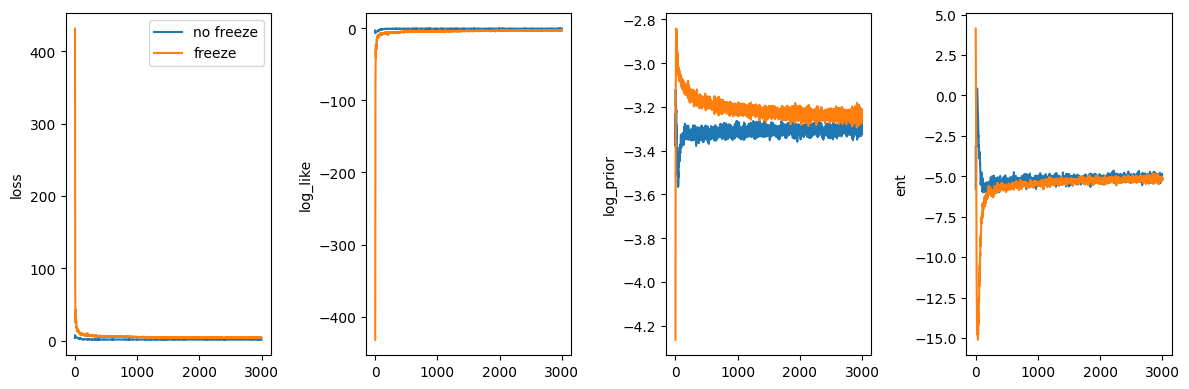

In [187]:
loss_keys = list(df_history.columns)
fig, ax = plt.subplots(1, len(loss_keys), figsize=(12, 4))
for i, k in enumerate(loss_keys):
    ax[i].plot(df_history[k], label="no freeze")
    ax[i].plot(df_freeze_history[k], label="freeze")
    ax[i].set_label("epoch")
    ax[i].set_ylabel(k)
ax[0].legend()
plt.tight_layout()
plt.show()

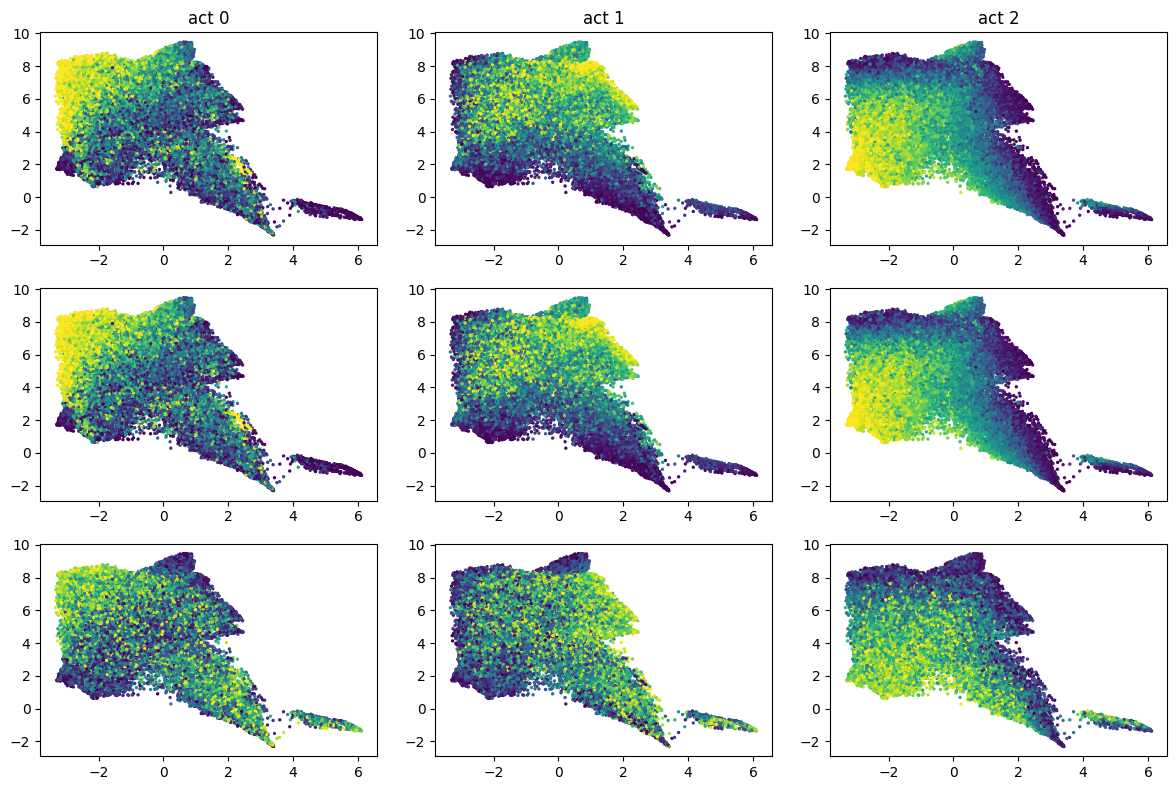

In [188]:
# visualize latents
with torch.no_grad():
    pred = rpm.encode(features_single_norm).mode
    pred_f = rpm.f.encode(features_single_norm).mode
    
fig, ax = plt.subplots(3, act_dim, figsize=(4 * act_dim, 8))
for i in range(act_dim):
    ax[0, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=pred[:, i], s=2)
    ax[1, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=pred_f[:, i], s=2)
    ax[2, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=actions_single[:, i], s=2)
    ax[0, i].set_title(f"act {i}")
plt.tight_layout()
plt.show()

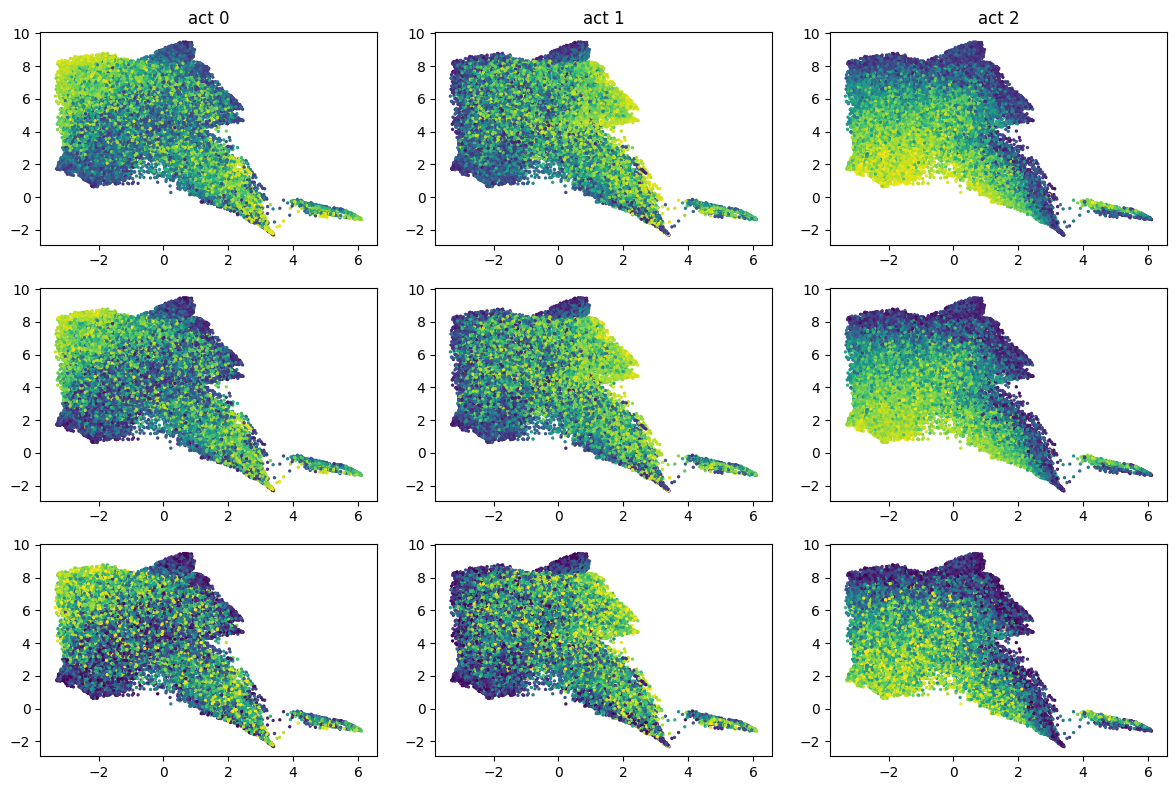

In [190]:
# visualize latents freeze
with torch.no_grad():
    pred = rpm_freeze.encode(features_single_norm).mode
    pred_f = rpm_freeze.f.encode(features_single_norm).mode
    
fig, ax = plt.subplots(3, act_dim, figsize=(4 * act_dim, 8))
for i in range(act_dim):
    ax[0, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=pred[:, i], s=2)
    ax[1, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=pred_f[:, i], s=2)
    ax[2, i].scatter(embeddings_single[:, 0], embeddings_single[:, 1], c=actions_single[:, i], s=2)
    ax[0, i].set_title(f"act {i}")
plt.tight_layout()
plt.show()